##**Importing libraries**

In [ ]:
!git clone https://github.com/leeyeehoo/CSRNet-pytorch

Cloning into 'CSRNet-pytorch'...
remote: Enumerating objects: 86, done.
remote: Total 86 (delta 0), reused 0 (delta 0), pack-reused 86
Unpacking objects: 100% (86/86), done.


In [ ]:
# importing libraries
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import shutil
import os
import glob
import matplotlib.pyplot as plt 
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from torch.utils.data import Dataset
import scipy
import json
from matplotlib import cm
import torch
from tqdm import tqdm   
from scipy import spatial
import scipy
from scipy.ndimage.filters import gaussian_filter
%matplotlib inline

In [ ]:
# from google drive import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**utils**

In [ ]:
def save_net(fname, net):
    with h5py.File(fname, 'w') as h5f:
        for k, v in net.state_dict().items():
            h5f.create_dataset(k, data=v.cpu().numpy())
def load_net(fname, net):
    with h5py.File(fname, 'r') as h5f:
        for k, v in net.state_dict().items():        
            param = torch.from_numpy(np.asarray(h5f[k]))         
            v.copy_(param)
            
def save_checkpoint(state, is_best,task_id, filename='checkpoint.pth.tar'):
    torch.save(state, "/content/drive/MyDrive/ShanghaiTech_Crowd_Counting_Dataset/checkpoint.pth.tar")
    if is_best:
        shutil.copyfile("/content/drive/MyDrive/ShanghaiTech_Crowd_Counting_Dataset/checkpoint.pth.tar", task_id+'model_best.pth.tar')

##**Dataset**

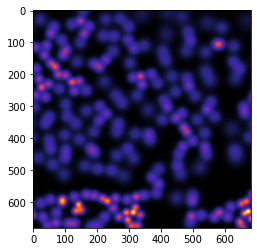

Sum =  191.02182


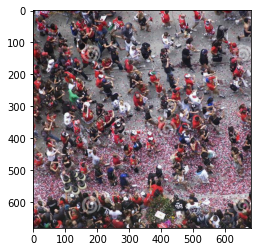

In [ ]:
#show the density map corresponding to the image.
#density map
file_path = '/content/drive/MyDrive/ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data/ground_truth/IMG_146.npy'
gt_file = np.load(file_path)
groundtruth = np.asarray(gt_file)
image = plt.imshow(groundtruth,cmap=cm.CMRmap)
plt.show(image)
print("Sum = " ,np.sum(groundtruth))

#open the image corresponding to the density map.
file = '/content/drive/MyDrive/ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data/ground_truth/IMG_146.h5'
imag = Image.open(file.replace('.h5', '.jpg').replace('ground_truth', 'images'))
a = plt.imshow(imag)
plt.show(a)

In [ ]:
def load_data(img_path,train = True):
    gt_path = img_path.replace('.jpg','.npy').replace('images','ground_truth')
    img = Image.open(img_path).convert('RGB')
    target = np.load(gt_path)
    if False:
        crop_size = (img.size[0]/2,img.size[1]/2)
        if random.randint(0,9)<= -1:
            dx = int(random.randint(0,1)*img.size[0]*1./2)
            dy = int(random.randint(0,1)*img.size[1]*1./2)
        else:
            dx = int(random.random()*img.size[0]*1./2)
            dy = int(random.random()*img.size[1]*1./2)
        img = img.crop((dx,dy,crop_size[0]+dx,crop_size[1]+dy))
        target = target[dy:crop_size[1]+dy,dx:crop_size[0]+dx]

        if random.random()>0.8:
            target = np.fliplr(target)
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
    return img,target

In [ ]:
from torchvision.transforms import InterpolationMode
class listDataset(Dataset):
    def __init__(self, root, shape=None, shuffle=True, transform=None, target_transform=None,  train=False, seen=0, batch_size=1, num_workers=4):
        if train:
            root = root * 4
        random.shuffle(root)
        
        self.nSamples = len(root)
        self.lines = root
        self.transform = transform
        self.target_transform = target_transform
        self.train = train
        self.shape = shape
        self.seen = seen
        self.batch_size = batch_size
        self.num_workers = num_workers
        
        
    def __len__(self):
        return self.nSamples
    def __getitem__(self, index):
        assert index <= len(self), 'index range error' 
        
        img_path = self.lines[index]
        
        img,target = load_data(img_path,self.train)
        
        #img = 255.0 * F.to_tensor(img)
        
        #img[0,:,:]=img[0,:,:]-92.8207477031
        #img[1,:,:]=img[1,:,:]-95.2757037428
        #img[2,:,:]=img[2,:,:]-104.877445883


        
        
        if self.transform is not None:
          img = self.transform(img)

        if self.target_transform is not None:
          ratio = target.shape[0]/768
          target = cv2.resize(target,(768,768),interpolation = cv2.INTER_CUBIC)*(ratio**2)
          target = cv2.resize(target,(int(target.shape[1]/8),int(target.shape[0]/8)),interpolation = cv2.INTER_CUBIC)*64
          target = torch.tensor(target, dtype=torch.float32).unsqueeze(0)
        
        return img,target

##**Generate the ground truth and density map**



In [ ]:
# function to create density maps for images
def gaussian_filter_density(gt):
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
      return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    return density

In [ ]:
root = '/content/drive/MyDrive/ShanghaiTech_Crowd_Counting_Dataset'

In [ ]:
# generate the ground truth values for images in part_A and part_B
part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B/test_data','images')
path_sets = [part_A_train,part_A_test]

In [ ]:
#image location
img_paths = []
for path in path_sets:
  for img_path in glob.glob(os.path.join(path, '*.jpg')):
    img_paths.append(img_path)

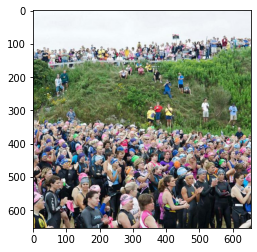

In [ ]:
# see a sample image
plt.imshow(Image.open(img_paths[7]))

In [ ]:
# plot its ground truth heatmap
gt_file = img_paths[7].replace('.jpg','.npy').replace('images','ground_truth')
groundtruth = np.load(gt_file)
h, w = groundtruth.shape
short = min(h, w)
if h < w:
  groundtruth = groundtruth[:,int(w/2-short/2):int(w/2+short/2)]
else:
  groundtruth = groundtruth[int(h/2-short/2):int(h/2+short/2),:]



In [ ]:
gt_file

'/content/drive/MyDrive/ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data/ground_truth/IMG_100.npy'

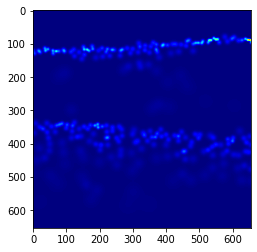

In [ ]:
plt.imshow(groundtruth,cmap=cm.jet)

In [ ]:
# count how many people are present in this image
np.sum(groundtruth)

242.45515

##**Crop Image**


In [ ]:
# file = "/content/drive/MyDrive/ShanghaiTech_Crowd_Counting_Dataset"
# for i in glob.glob(os.path.join(file, "part_A_final", "test_data", "ground_truth", "*.mat")):
#   os.remove(i)


In [ ]:
from PIL import Image
import torchvision
import glob
file = "/content/drive/MyDrive/ShanghaiTech_Crowd_Counting_Dataset"
for i in glob.glob(os.path.join(file, "part_B_final", "test_data", "images", "*jpg")):
  img = Image.open(i)
  print("before: ")
  print(img.size)
  w, h = img.size
  short = min(w, h)
  crop = torchvision.transforms.CenterCrop(short)
  img = crop(img)
  img.save(i)
  print("after: ")
  print(img.size)

before: 
(768, 768)
after: 
(768, 768)
before: 
(768, 768)
after: 
(768, 768)
before: 
(768, 768)
after: 
(768, 768)
before: 
(768, 768)
after: 
(768, 768)
before: 
(768, 768)
after: 
(768, 768)
before: 
(768, 768)
after: 
(768, 768)
before: 
(768, 768)
after: 
(768, 768)
before: 
(768, 768)
after: 
(768, 768)
before: 
(768, 768)
after: 
(768, 768)
before: 
(768, 768)
after: 
(768, 768)
before: 
(768, 768)
after: 
(768, 768)
before: 
(768, 768)
after: 
(768, 768)
before: 
(768, 768)
after: 
(768, 768)
before: 
(768, 768)
after: 
(768, 768)
before: 
(768, 768)
after: 
(768, 768)
before: 
(768, 768)
after: 
(768, 768)
before: 
(768, 768)
after: 
(768, 768)
before: 
(768, 768)
after: 
(768, 768)
before: 
(768, 768)
after: 
(768, 768)
before: 
(768, 768)
after: 
(768, 768)
before: 
(768, 768)
after: 
(768, 768)
before: 
(768, 768)
after: 
(768, 768)
before: 
(768, 768)
after: 
(768, 768)
before: 
(768, 768)
after: 
(768, 768)
before: 
(768, 768)
after: 
(768, 768)
before: 
(768, 768)
after

In [ ]:
from PIL import Image
import torchvision
import glob
file = "/content/drive/MyDrive/ShanghaiTech_Crowd_Counting_Dataset"
for i in glob.glob(os.path.join(file, "part_B_final", "test_data", "ground_truth", "*h5")):
  gt_file = h5py.File(i,'r')
  groundtruth = np.asarray(gt_file['density'])
  h, w = groundtruth.shape
  short = min(h, w)
  if h < w:
    groundtruth = groundtruth[:,int(w/2-short/2):int(w/2+short/2)]
  else:
    groundtruth = groundtruth[int(h/2-short/2):int(h/2+short/2),:]
  np.save(i.replace(".h5", ""), groundtruth)


In [ ]:
import torchvision
torchvision.transforms.CenterCrop(1024)

CenterCrop(size=(1024, 1024))

In [ ]:
torchvision.transforms.Resize(1024 ,interpolation=torchvision.transforms.InterpolationMode.BILINEAR)

Resize(size=1024, interpolation=bilinear, max_size=None, antialias=None)